In [ ]:
!pip install git+https://github.com/fastai/fastcore.git
!pip install git+https://github.com/fastai/fastai2.git

In [ ]:
!pip list fastcore

In [ ]:
!pip install --upgrade fastcore==1.0.9

In [ ]:
!pip install fastbook

In [6]:
from fastbook import *
from fastai.vision.widgets import *

# Dataset
### from kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [8]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d 'alxmamaev/flowers-recognition'

 98% 220M/225M [00:02<00:00, 94.9MB/s]
100% 225M/225M [00:02<00:00, 103MB/s] 


In [10]:
! mkdir flowers-recognition

In [ ]:
! unzip flowers-recognition.zip -d flowers-recognition

In [12]:
path = Path("flowers-recognition/flowers")

In [13]:
flower = DataBlock(blocks = (ImageBlock, CategoryBlock), #輸入數據是圖像(自變量), 標籤是花的種類(因變量)
                  get_items = get_image_files, #取得資料方式
                  get_y = parent_label, #parent_label找網上一層路徑名稱
                  splitter = RandomSplitter(valid_pct = 0.2, seed = 123), #隨機分成train和validation(20%),seed表示出來的結果都相同
                  item_tfms = Resize(224), #將這些圖像調整為相同大小
                  batch_tfms = aug_transforms(mult = 1.5) #影像增強
                  )

In [ ]:
dls = flower.dataloaders(path, bs = 8) 

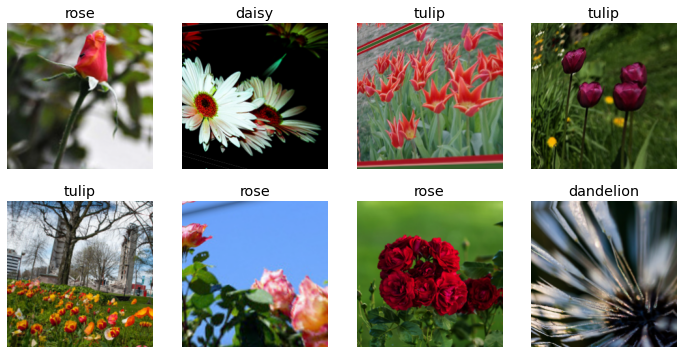

In [16]:
dls.show_batch()

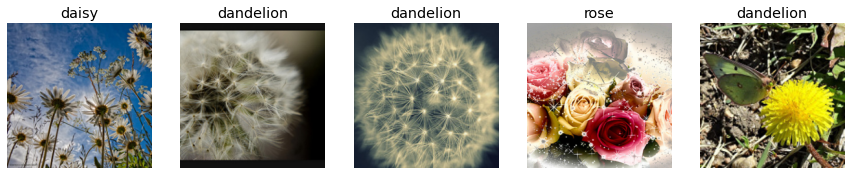

In [17]:
dls.valid.show_batch(max_n=5, nrows=1)

# Training Model

In [18]:
learner = cnn_learner(dls, resnet34, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [19]:
learner.summary()

Sequential (Input shape: 8 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

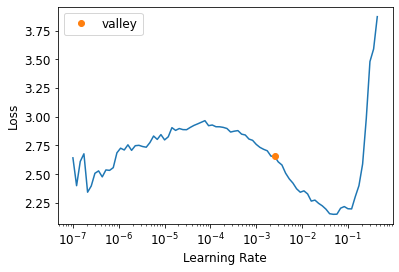

In [20]:
recorder = learner.lr_find()

In [21]:
torch.cuda.empty_cache()

In [22]:
learner.fit_one_cycle(12, lr_max = 1e-3) #lr_max找最合適的learning rate

epoch,train_loss,valid_loss,error_rate,time
0,1.052148,0.504836,0.180765,01:29
1,0.781344,0.416517,0.147161,01:29
2,0.655449,0.386864,0.126304,01:29
3,0.608133,0.353972,0.120510,01:29
4,0.493712,0.310712,0.106605,01:29
5,0.444649,0.321140,0.104287,01:28
6,0.457985,0.313919,0.114716,01:28
7,0.361096,0.280461,0.092700,01:29
8,0.342967,0.269453,0.092700,01:29
9,0.339297,0.272830,0.093859,01:28


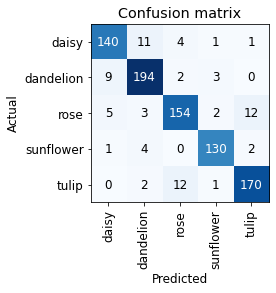

In [25]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [34]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)

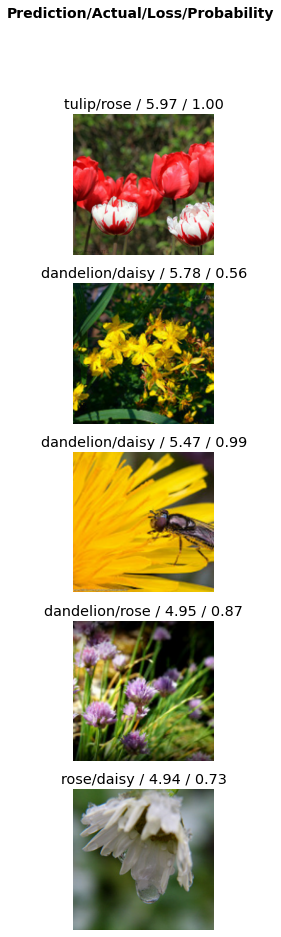

In [39]:
plot_top_losses_fix(interp, 5, nrows=5)

#Predict

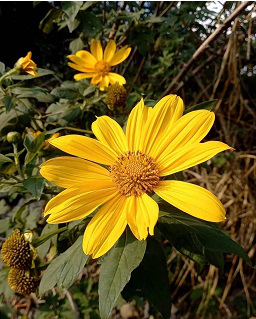

In [53]:
img = PILImage.create("/content/drive/MyDrive/flower1.jpg")
img

In [54]:
learner.predict(img)

('sunflower',
 TensorBase(3),
 TensorBase([0.4247, 0.0766, 0.0013, 0.4947, 0.0026]))

In [55]:
dls.vocab  #類別順序

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

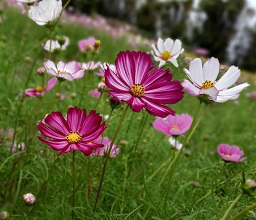

In [56]:
img2 = PILImage.create("/content/drive/MyDrive/flower2.jpg")
img2

In [57]:
learner.predict(img2)

('daisy',
 TensorBase(0),
 TensorBase([7.7688e-01, 1.0921e-03, 8.2391e-02, 8.6841e-05, 1.3955e-01]))